# Face mask detection

Here I am going to detect whether a person is wearing mask or not. I am focussing on only two classes that are 'face_with_mask' and face_no_mask'.

## Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.4 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from mtcnn.mtcnn import MTCNN

# Loading datasets

In [ ]:
images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
annotations=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
train=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/train.csv"))

In [ ]:
print(len(train))
train.head()

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [ ]:
len(os.listdir(images))

6024

## We are having 6024 images.

In [ ]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()

In [ ]:
print(len(b),len(a))

4326 6024


In [ ]:
train_images=a[1698:]
test_images=a[:1698]

In [ ]:
test_images[0]

'0001.jpg'

Let's see some of the images.

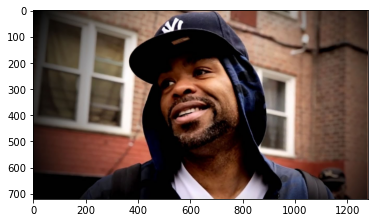

In [ ]:
img=plt.imread(os.path.join(images,test_images[0]))
plt.imshow(img)
plt.show()

In [ ]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

[[112, 113, 262, 307]]


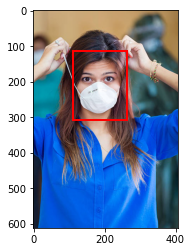

In [ ]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox  
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[3]))
image=train_images[3]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

<BarContainer object of 2 artists>

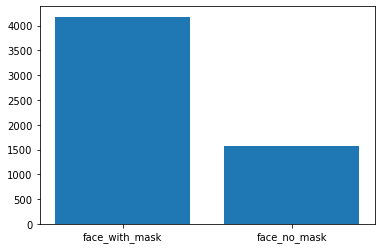

In [ ]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

# Creating training data

In [ ]:
img_size=50
data=[]
path='/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/'
def create_data():
       for i in range(len(train)):
            arr=[]
            for j in train.iloc[i]:
                   arr.append(j)
            img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
            crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            new_img_array=cv2.resize(crop_image,(img_size,img_size))
            data.append([new_img_array,arr[5]])
create_data()      

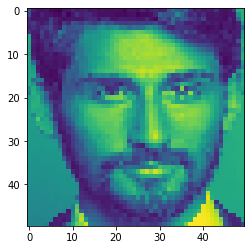

In [ ]:
data[0][0]
plt.imshow(data[0][0])

In [ ]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)

In [ ]:
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

# Model Fitting

In [ ]:
from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3),input_shape=x.shape[1:],activation='relu',strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [ ]:

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
model.fit(x,y,epochs=30,batch_size=5)

Epoch 1/30
5749/5749 [==============================] - 9s 2ms/step - loss: 0.5409 - accuracy: 0.7389
Epoch 2/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.4530 - accuracy: 0.7913
Epoch 3/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.4080 - accuracy: 0.8179
Epoch 4/30
5749/5749 [==============================] - 9s 2ms/step - loss: 0.3679 - accuracy: 0.8342
Epoch 5/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.3311 - accuracy: 0.8581
Epoch 6/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.3022 - accuracy: 0.8702
Epoch 7/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.2723 - accuracy: 0.8843
Epoch 8/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.2487 - accuracy: 0.8897
Epoch 9/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.2344 - accuracy: 0.9002
Epoch 10/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.207

In [ ]:
detector=MTCNN()
test_df=[]
for image in test_images:
    img=plt.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test=[]
    for face in faces:
        bounding_box=face['box']
        test.append([image,bounding_box])
    test_df.append(test)
test=[]
for i in test_df:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)  
sub=[]
rest_image=[]
for i in test:
    sub.append(i[0])
for image in test_images:
    if image not in sub:
        rest_image.append(image) 
detector=MTCNN()
test_df_=[]
for image in rest_image:
    img=cv2.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test_=[]
    for face in faces:
        bounding_box=face['box']
        test_.append([image,bounding_box])
    test_df_.append(test_) 
for i in test_df_:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)      

In [ ]:
negative=[]
for i in test:
    for j in i[1]:
        if j<0:
            negative.append(i)
    

In [ ]:
test_data=[]
def create_test_data():
            for j in test:
                if j not in negative:
                    img=cv2.imread(os.path.join(images,j[0]),cv2.IMREAD_GRAYSCALE)
                    img=img[j[1][1]:j[1][1]+j[1][3],j[1][0]:j[1][0]+j[1][2]]
                    new_img=cv2.resize(img,(50,50))
                    new_img=new_img.reshape(-1,50,50,1)
                    predict=model.predict(new_img)
                    test_data.append([j,predict])

create_test_data()      

In [ ]:
image=[]
classname=[]
for i,j in test_data:
    classname.append(np.argmax(j))
    image.append(i)
df=pd.DataFrame(columns=['image','classname'])
df['image']=image
df['classname']=classname
df['classname']=lbl.inverse_transform(df['classname'])
image=[]
x1=[]
x2=[]
y1=[]
y2=[]
for i in df['image']:
    image.append(i[0])
    x1.append(i[1][0])
    x2.append(i[1][1])
    y1.append(i[1][2])
    y2.append(i[1][3])
df['name']=image
df['x1']=x1
df['x2']=x2
df['y1']=y1
df['y2']=y2    
df.drop(['image'],axis=1,inplace=True)

In [ ]:
df.sort_values('name',axis=0,inplace=True,ascending=False)
df.to_csv('submission_1.csv')

In [ ]:
model.save("mask.h5")